<a href="https://colab.research.google.com/github/daleas0120/Example_notebooks/blob/main/Persistence_Diagram_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Persistence homology can be a good tool for studying how data clusters at a variety of different scales.  I found the following papers to be a useful background in understanding how to implement this kind of analysis:

- [*An Introduction to Topological Data Analysis: Fundamental and Practical Aspects for Data Scientists*](https://www.frontiersin.org/articles/10.3389/frai.2021.667963/full?ref=graphusergroup.com) by Chazal et al.
- [*Topological Persistence and Simplification*](https://link.springer.com/article/10.1007/s00454-002-2885-2) by Edelsbrunner et al.
- [*Stability of persistence diagrams*](https://dl.acm.org/doi/abs/10.1145/1064092.1064133?casa_token=jHEf2zdQuBIAAAAA:YDNDN7xF1t-ClgvyeKft3E2Gyc3VlwZuT6nRtHTdw6vGoJuykcCWI2YxFO7fh4FYUi0WmSEtR4dcaA) by Cohen-Steiner et al.


This notebook uses [`persim`](https://persim.scikit-tda.org/en/latest/) and [`gudhi`](https://gudhi.inria.fr/python/latest/) python libraries to analyze four different data distributions: normal, uniform, concentric rings, and noisy concentric rings.  I found it useful to implement both (rather than one over the other) due to ease of use and memory consumption.  If you execute this notebook in Google colab, it is fun to watch the RAM usage plot change...

In [1]:
!pip install --quiet persim &> /dev/null

In [2]:
!pip install --quiet gudhi &> /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import persim
import gudhi as gd

from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from sklearn import datasets

# Example Data Distributions

## Uniform Distribution

In [4]:
# Uniform distribution
uni_x = np.linspace(0, 1, 700)
uni_y = np.random.uniform(0, 1, 700)

# 1. Generate pair-wise distance matrix
uniform_data = np.transpose(np.array([uni_x,uni_y]))
uniform_dist = pairwise_distances(uniform_data)

# 2. Generate simplical complexes
uniform_rips = gd.RipsComplex(
    distance_matrix = uniform_dist,
)

#3. Generate simplex tree
uniform_tree = uniform_rips.create_simplex_tree(max_dimension = 2)

# 4. Get persistence
uniform_barcode = uniform_tree.persistence()

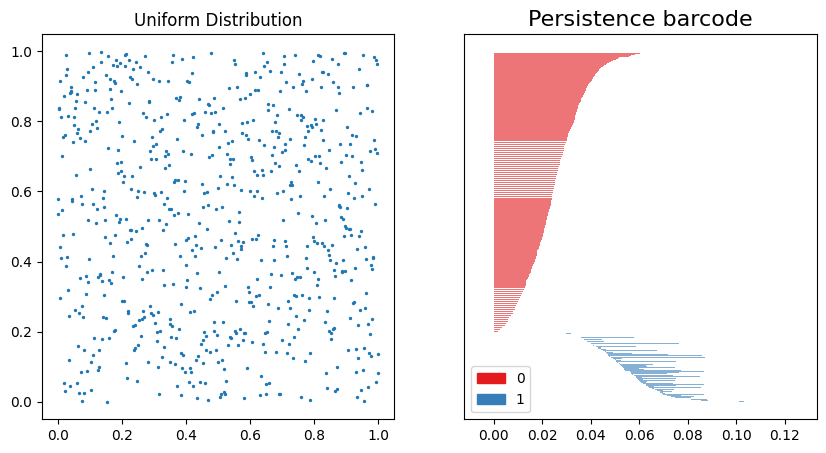

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(uni_x, uni_y, s=2)
ax[0].set_title("Uniform Distribution")
#plt.sca(ax[1])
gd.plot_persistence_barcode(uniform_barcode, axes=ax[1])
plt.show()

On the left, the data distribution is shown to be evenly distributed from 0 to 1.  On the right, the Persistence Barcode shows the 0th-order homology in red, and the 1st-order homology in blue.  The distance scale on the x-axis shows that the clustering dynamics stabilize at $\approx 0.13$.



In [6]:
# The following variables will be deleted to free up memory
del uniform_data
del uniform_dist
del uniform_rips
del uniform_tree

## Normal Distribution



In [7]:
norm_x = np.random.normal(0, 0.3, 700)
norm_y = np.random.normal(0, 0.3, 700)

# 1. Generate pair-wise distance matrix
norm_data = np.transpose(np.array([norm_x,norm_y]))
norm_dist = pairwise_distances(norm_data)

# 2. Generate simplical complexes
norm_rips = gd.RipsComplex(
    distance_matrix = norm_dist,
)

#3. Generate simplex tree
norm_tree = norm_rips.create_simplex_tree(max_dimension = 2)

# 4. Get persistence
norm_barcode = norm_tree.persistence()

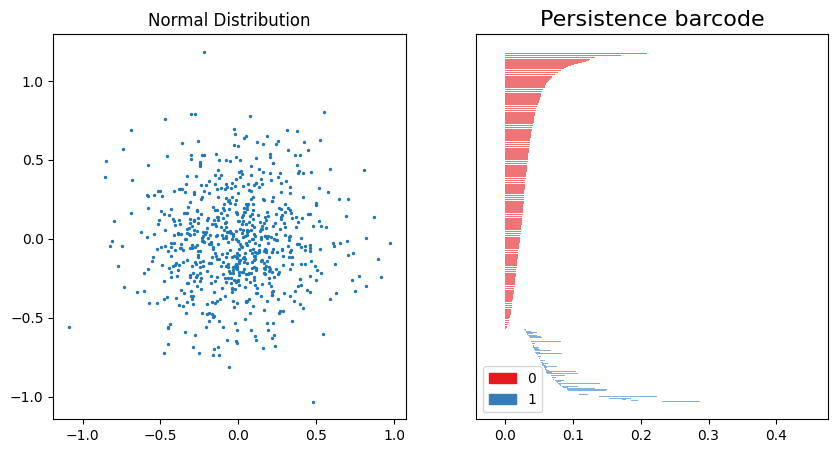

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(norm_x, norm_y, s=2)
ax[0].set_title("Normal Distribution")

gd.plot_persistence_barcode(norm_barcode, axes=ax[1])
plt.show()

We can compare this Persistence barcode to the one created for the uniform distribution.  Note that the scale is larger, reflecting the difference in range for the data (-1.0 to 1.0 for the normal distribution).  The 0th-order homology also has a longer "tail" for the normal distribution than the uniform distribution.

In [9]:
# The following variables will be deleted to free up memory
del norm_data
del norm_dist
del norm_rips
del norm_tree

Now we can create Birth-Death diagrams for each of the Persistence barcode plots above.  For each point, the `x` coordinate is the radius at which the structure begins, and the `y` coordinate is the radius at which the structure ends.  Points at $∞$ represent structures which still exist past the $0.13$ end point shown in the Persistence Barcode.

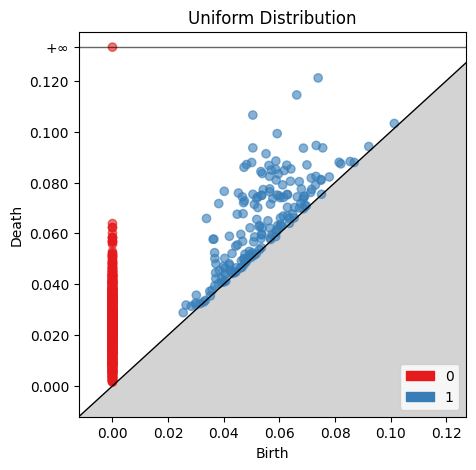

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
gd.plot_persistence_diagram(uniform_barcode, axes=ax, fontsize=10)
ax.set_title('Uniform Distribution')
plt.show()

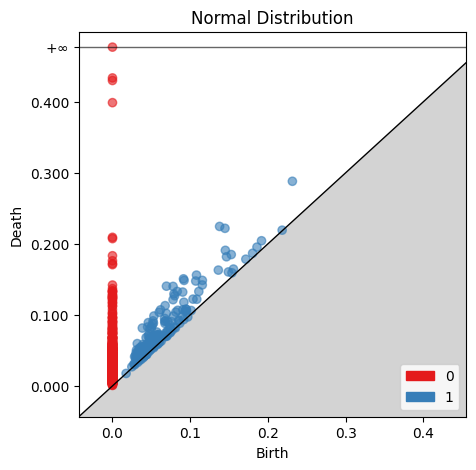

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
gd.plot_persistence_diagram(norm_barcode, axes=ax, fontsize=10)
ax.set_title('Normal Distribution')
plt.show()

Up to this point, I have used Gudhi's libraries for computing the persistence diagrams.  I am going to convert the data to a Persim compatible format since I found the bottleneck distance calculation in Persim to be faster and more memory friendly.  I will keep only the 1st-order homology since this is used to compute the bottleneck distance.

The **bottleneck distance**, *B*, is the minimum distance which allows every point to be mapped to some other point; the distance between all pairwise mappings on the persistence diagram is less than or equal to the bottleneck distance. This distance is found by performing a binary search with the Hopcroft-Karp algorithm on the cosine similarity matrix (CSM) of the two birth-death diagrams.

In [12]:
uniform_persis = np.array([itm[1] for itm in uniform_barcode])
norm_persis = np.array([itm[1] for itm in norm_barcode])

In [13]:
dist, matching = persim.bottleneck(uniform_persis, norm_persis, matching=True)
print("Bottleneck distance: ", dist)

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Bottleneck distance:  0.21679964357072135


I can also print the coordinates of the two birth-death points connected by the bottleneck distance.

In [14]:
max_idx = np.argmax(matching[:, 2])
[i, j, d] = matching[max_idx, :]
i = int(i)
j = int(j)
print('Confirm that we have found the bottleneck distance: ', d)
print('Uniform Persistence Coordinate: ', [uniform_persis[i, 0], uniform_persis[i, 1]])
print('Normal Persistence Coordinate: ', [norm_persis[j, 0], norm_persis[j, 1]])

Confirm that we have found the bottleneck distance:  0.21679964357072135
Uniform Persistence Coordinate:  [0.0, 0.001497319473035949]
Normal Persistence Coordinate:  [0.0, inf]


Finally, we can plot the matchings between the two birth-death persistence diagrams:

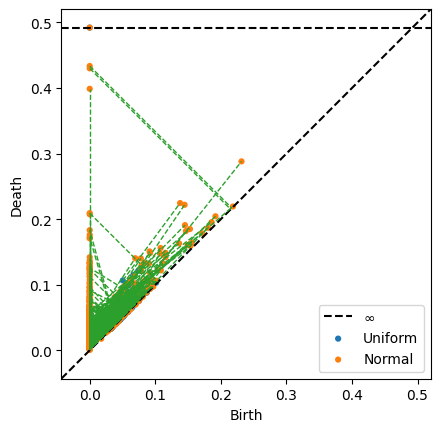

In [15]:
persim.bottleneck_matching(np.array(uniform_persis), np.array(norm_persis), matching=matching, labels=['Uniform', 'Normal'], ax=None)

There are many matchings, which obscures the bottleneck distance pair.  However, it is clear that the normal distribution has a larger range than the uniform distribution.

In [16]:
# The following variables will be deleted to free up memory
del norm_x
del norm_y
del uni_x
del uni_y

## Concentric Rings #1

The normally-distributed and uniformly-distributed data showed interesting 0th-order homology.  Using a ring-type structure for the data will help demonstrate the 1st-order homology.

In [17]:
ring_data = sklearn.datasets.make_circles(700, factor=0.01)

# 1. Generate pair-wise distance matrix
rings_data = np.transpose(np.array([ring_data[0][:, 0],ring_data[0][:, 1]]))
rings_dist = pairwise_distances(rings_data)

# 2. Generate simplical complexes
rings_rips = gd.RipsComplex(
    distance_matrix = rings_dist,
)

#3. Generate simplex tree
rings_tree = rings_rips.create_simplex_tree(max_dimension = 2)

# 4. Get persistence
rings_barcode = rings_tree.persistence()

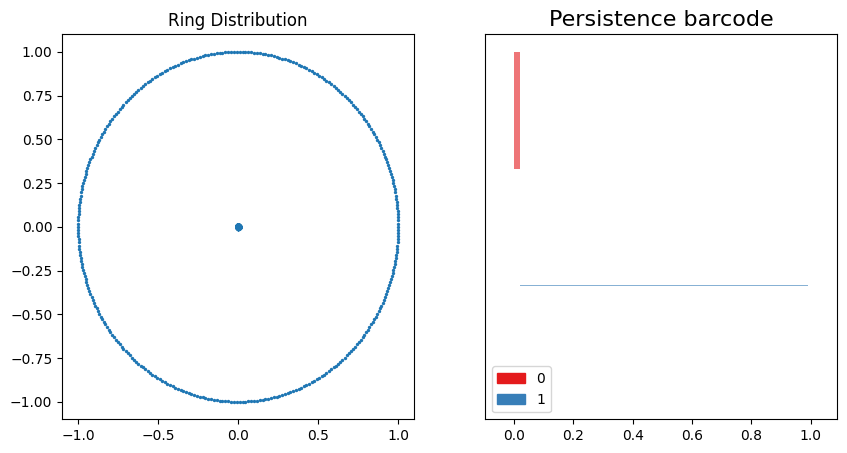

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(ring_data[0][:, 0], ring_data[0][:, 1], s=2)
ax[0].set_title("Ring Distribution")
gd.plot_persistence_barcode(rings_barcode, axes=ax[1])
plt.show()

This data distribution and persistence barcode pair are fairly easy to interpret.  The 0th-order homology clusters for a well defined range because the points on the ring circumference are evenly distributed around the perimeter.  As the points increase their connectivity, the 1st-order homology emerges at the exact point where the 0th-order homologies end.

## Concentric Rings #2

In [19]:
ring_data2 = sklearn.datasets.make_circles(700, factor=0.01, noise=0.05)

# 1. Generate pair-wise distance matrix
rings_data2 = np.transpose(np.array([ring_data2[0][:, 0],ring_data2[0][:, 1]]))
rings_dist2 = pairwise_distances(rings_data2)

# 2. Generate simplical complexes
rings_rips2 = gd.RipsComplex(
    distance_matrix = rings_dist2,
)

#3. Generate simplex tree
rings_tree2 = rings_rips2.create_simplex_tree(max_dimension = 2)

# 4. Get persistence
rings_barcode2 = rings_tree2.persistence()

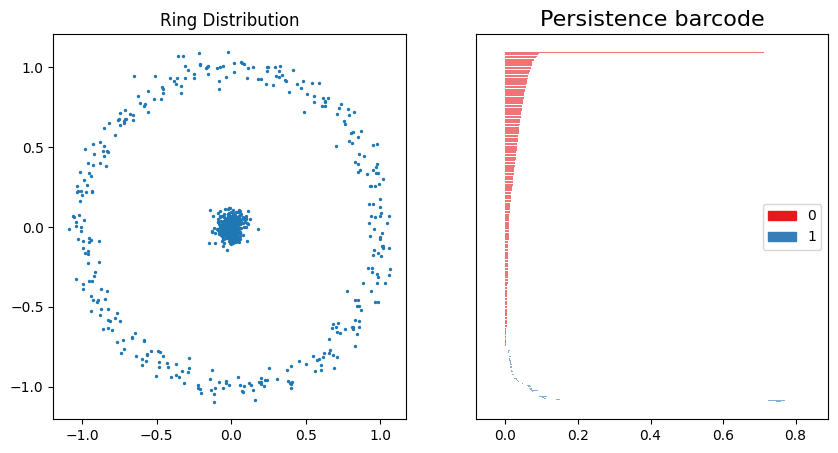

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(ring_data2[0][:, 0], ring_data2[0][:, 1], s=2)
ax[0].set_title("Ring Distribution")
gd.plot_persistence_barcode(rings_barcode2, axes=ax[1])
plt.show()

With some gaussian noise added, these plots are comparable to both the normal distribution persistence barcode plot and the concentric ring persistence barcode plot above.  A large 1st-order homology structure is shown from $\approx 0.1$ to $\approx 0.8$, which roughly correlates with the distance between the center cluster and the ring with diameter $\approx 1$.

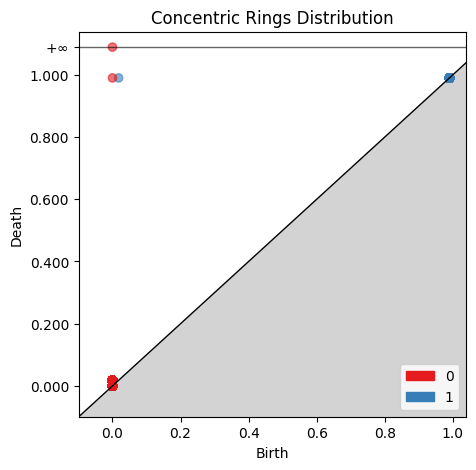

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
gd.plot_persistence_diagram(rings_barcode, axes=ax, fontsize=10)
ax.set_title('Concentric Rings Distribution')
plt.show()

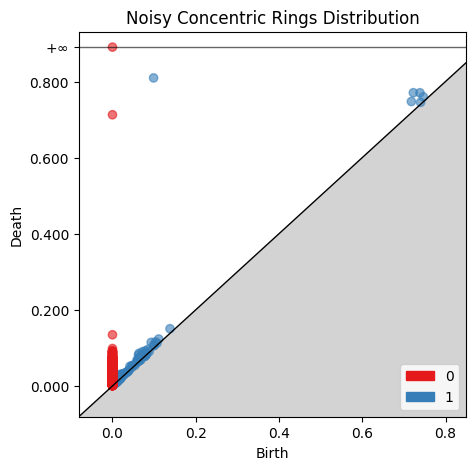

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
gd.plot_persistence_diagram(rings_barcode2, axes=ax, fontsize=10)
ax.set_title('Noisy Concentric Rings Distribution')
plt.show()

Comparing the two birth-death plots to the original persistence barcode plots helps identify where the features are originating.  For example, the cluster of blue points just off the main diagonal of the normally distributed birth-death digram corresponds to the 1st-order homologies between 0 and 0.2 on the original persistence barcode plot.

In [23]:
# convert data for use in persim
rings_persis = np.array([itm[1] for itm in rings_barcode])
rings2_persis = np.array([itm[1] for itm in rings_barcode2])

In [24]:
dist2, matching2 = persim.bottleneck(rings_persis, rings2_persis, matching=True)
print("Bottleneck distance: ", dist2)

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Bottleneck distance:  0.27734036348549507


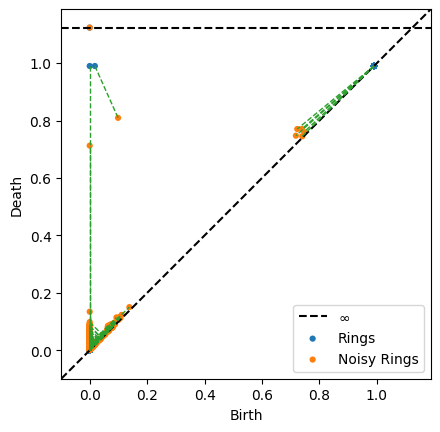

In [25]:
persim.bottleneck_matching(np.array(rings_persis), np.array(rings2_persis), matching=matching2, labels=['Rings', 'Noisy Rings'], ax=None)

In [26]:
# The following variables will be deleted to free up memory
del rings_data
del rings_data2
del rings_barcode
del rings_barcode2
del rings_tree
del rings_tree2
del rings_rips
del rings_rips2
del ring_data
del ring_data2

# Bottleneck Distance Comparison

Finally, we can confirm that the bottleneck distance is capturing the difference between the different distributions.  The bottleneck distance should be smaller between the two ring distributions than either the uniformly or normally distributed distributions.

In [27]:
dist3, matching3 = persim.bottleneck(rings_persis, norm_persis, matching=True)
dist4, matching4 = persim.bottleneck(rings2_persis, norm_persis, matching=True)
dist5, matching5 = persim.bottleneck(rings2_persis, uniform_persis, matching=True)
dist6, matching6 = persim.bottleneck(rings_persis, uniform_persis, matching=True)

/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


In [28]:
print("Uniform to normally distributed data bottleneck distance: ", dist)
print("Rings to noisy rings bottleneck distance: ", dist2)
print("Rings to normally distributed data bottleneck distance: ", dist3)
print("Noisy rings to normally distributed data bottleneck distance: ", dist4)
print("Noisy rings to uniformly distributed data bottleneck distance: ", dist5)
print("Rings to uniformly distributed data bottleneck distance: ", dist6)

Uniform to normally distributed data bottleneck distance:  0.21679964357072135
Rings to noisy rings bottleneck distance:  0.27734036348549507
Rings to normally distributed data bottleneck distance:  0.49499999999999994
Noisy rings to normally distributed data bottleneck distance:  0.3553335494268177
Noisy rings to uniformly distributed data bottleneck distance:  0.3563298182572524
Rings to uniformly distributed data bottleneck distance:  0.49499999999999994


# Summary

The four different data distributions were analyzed using persistence barcode plots, birth-death plots, and the bottleneck distance.  The bottleneck distance captured the similarities between the normally and uniformly distributed data, and the similarities between the two different ring distributions.